# Multi-Objective Optimization (MOO) PINN with GradNorm

### 1. Introduction: Balancing Competing Losses with GradNorm

This notebook provides a runnable example of training a PINN using a **Multi-Objective Optimization (MOO)** strategy, specifically the **GradNorm** algorithm.

Standard PINNs often struggle to balance the different components of their loss function (e.g., PDE residual and boundary conditions). GradNorm addresses this by dynamically adjusting the weights of each loss term to ensure they all learn at a similar rate, preventing any single term from dominating and stalling training.

### 2. Problem Definition: 1D Poisson's Equation

We will solve a simple 1D Poisson's equation as a demonstration.
-   **PDE:** $-u_{xx} = \pi^2 \sin(\pi x)$
-   **Domain:** $x \in [-1, 1]$
-   **BCs:** $u(-1) = u(1) = 0$
-   **Analytical Solution:** $u(x) = \sin(\pi x)$

### 3. Implementation Approach

Implementing GradNorm requires a **custom training loop** because we need to perform several steps that are not available in a standard training API. This includes calculating gradients for individual loss terms and updating the loss weights themselves.

This notebook implements the entire process in PyTorch, illustrating the algorithmic steps of GradNorm in a clear, runnable format.

In [12]:
from __future__ import annotations
import math
from dataclasses import dataclass
from typing import Tuple, List

import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

# -----------------------
# 0) Basic Setup & Utility Functions
# -----------------------
torch.manual_seed(42)
np.random.seed(42)

def to_tensor(x: np.ndarray, device: torch.device) -> torch.Tensor:
    return torch.from_numpy(x.astype(np.float32)).to(device)

def true_solution(x: np.ndarray) -> np.ndarray:
    # u*(x) = sin(pi x)
    return np.sin(np.pi * x).astype(np.float32)



### Step 1: Define Training Configuration and PINN Model

First, we define the basic components for our PINN:
1.  A `TrainConfig` dataclass to hold all hyperparameters.
2.  A simple feed-forward network (FNN) using PyTorch.

In [13]:
@dataclass
class TrainConfig:
    device: str = "cuda" if torch.cuda.is_available() else "cpu"
    n_pde: int = 256          # Collocation points per iteration
    n_bc_each: int = 64       # Boundary points per boundary
    iters: int = 6000
    lr_model: float = 1e-3
    lr_weights: float = 1e-3
    alpha: float = 0.5        # GradNorm hyperparameter
    log_every: int = 200

class FNN(nn.Module):
    def __init__(self, in_dim: int = 1, hidden: int = 64, depth: int = 3, out_dim: int = 1):
        super().__init__()
        layers: List[nn.Module] = [nn.Linear(in_dim, hidden), nn.Tanh()]
        for _ in range(depth - 1):
            layers += [nn.Linear(hidden, hidden), nn.Tanh()]
        layers += [nn.Linear(hidden, out_dim)]
        self.net = nn.Sequential(*layers)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.net(x)

### Step 2: Define PDE Residual and Loss Functions

Next, we define functions to compute the PDE residual and the boundary condition loss.
-   The `pde_residual` function computes the residual of the Poisson equation: $-(u_{xx} + \pi^2 \sin(\pi x))$.
-   The `bc_loss` function computes the mean squared error at the boundaries.

In [14]:
def pde_residual(model: nn.Module, x: torch.Tensor) -> torch.Tensor:
    """ -u_xx - pi^2 sin(pi x) = 0  => residual = -u_xx - source """
    x.requires_grad_(True)
    u = model(x)                              # (N,1)
    du_dx = torch.autograd.grad(u, x, torch.ones_like(u), create_graph=True)[0]
    d2u_dx2 = torch.autograd.grad(du_dx, x, torch.ones_like(du_dx), create_graph=True)[0]
    source = (math.pi ** 2) * torch.sin(math.pi * x)
    res = -d2u_dx2 - source
    return res

def bc_loss(model: nn.Module, x_bc: torch.Tensor) -> torch.Tensor:
    u = model(x_bc)
    return torch.mean(u ** 2)


### Step 3: GradNorm Custom Training Loop

This is the core of the implementation. The following function `train_gradnorm` contains the custom training loop that performs the GradNorm algorithm. The key steps inside the loop are:
1.  Compute separate losses for the PDE residual and BCs.
2.  Compute the total weighted loss and backpropagate to get gradients for the **model parameters**.
3.  Calculate the gradient norm for each individual weighted loss term with respect to the last layer's weights.
4.  Define the GradNorm loss, which measures the disparity between these norms.
5.  Backpropagate the GradNorm loss to get gradients for the **loss weights**.
6.  Update both the loss weights and the model parameters using their respective optimizers.
7.  Renormalize the loss weights.

In [15]:
def train_gradnorm(config: TrainConfig) -> Tuple[FNN, dict]:
    dev = torch.device(config.device)
    model = FNN().to(dev)

    # Two optimizers: one for model parameters, one for trainable loss weights
    opt_model = torch.optim.Adam(model.parameters(), lr=config.lr_model)

    # w = [w_pde, w_bc], initialized to 1.0 and made learnable
    loss_weights = torch.tensor([1.0, 1.0], dtype=torch.float32, requires_grad=True, device=dev)
    opt_w = torch.optim.Adam([loss_weights], lr=config.lr_weights)

    # History tracking
    hist = {
        "L_pde": [], "L_bc": [], "L_total": [],
        "W_pde": [], "W_bc": [],
        "G_pde": [], "G_bc": [],
    }

    # Pre-calculate initial losses L0 to be used as a baseline for relative training rates
    x_pde0 = to_tensor(np.random.rand(config.n_pde, 1) * 2 - 1, dev)  # [-1,1]

    # Explanation of sampling domain transformation:
    # np.random.rand(config.n_pde, 1) generates random values in [0, 1]
    # Multiply by 2: transforms to [0, 2] 
    # Subtract 1: transforms to [-1, 1]
    # This gives us random sampling points across the spatial domain [-1, 1] for the PDE

    r0 = pde_residual(model, x_pde0)
    L0_pde = torch.mean(r0 ** 2).detach()

    x_bc0 = to_tensor(np.array([[-1.0], [1.0]]).repeat(config.n_bc_each, axis=0), dev)
    L0_bc = bc_loss(model, x_bc0).detach()

    L0 = torch.stack([L0_pde, L0_bc]) + 1e-12  # Avoid division by zero

    # Initial losses (L0) are used as baselines for relative training rate calculations in GradNorm
    # x_pde0: Random sample points in [-1,1] for PDE residual evaluation
    # r0: PDE residual values at initial sample points
    # L0_pde: Initial PDE loss (mean squared residual) - measures how well PDE is satisfied initially
    # x_bc0: Boundary condition points at x=-1 and x=1, repeated n_bc_each times
    # L0_bc: Initial boundary condition loss - measures how well BCs are satisfied initially  
    # L0: Stack of [L0_pde, L0_bc] used for computing relative training rates L_i(t)/L_i(0)

    # --- Training Loop ---
    for it in range(1, config.iters + 1):
        model.train()
        opt_model.zero_grad()
        opt_w.zero_grad()

        # ---- 1. Compute individual losses ----
        x_pde = to_tensor(np.random.rand(config.n_pde, 1) * 2 - 1, dev)
        r = pde_residual(model, x_pde)
        L_pde = torch.mean(r ** 2)

        x_bc_left = to_tensor(-np.ones((config.n_bc_each, 1)), dev)
        x_bc_right = to_tensor(np.ones((config.n_bc_each, 1)), dev)
        x_bc = torch.cat([x_bc_left, x_bc_right], dim=0)
        L_bc = bc_loss(model, x_bc)
        losses = torch.stack([L_pde, L_bc])

        # ---- 2. Compute total weighted loss and backprop for model ----
        weighted_loss = (losses * loss_weights).sum()
        weighted_loss.backward(retain_graph=True) # Retain graph for GradNorm update

        # ---- 3. Compute gradient norms G_i for the last layer ----
        last_layer = model.net[-1].weight
        # create_graph=True is crucial as we need to backprop through the gradient norm G
        grad_pde, = torch.autograd.grad(loss_weights[0] * L_pde, last_layer, create_graph=True)
        grad_bc, = torch.autograd.grad(loss_weights[1] * L_bc, last_layer, create_graph=True)
        G_pde = torch.norm(grad_pde)
        G_bc = torch.norm(grad_bc)
        G = torch.stack([G_pde, G_bc])
        G_avg = torch.mean(G)

        # ---- 4. Define GradNorm loss ----
        L_ratio = (losses.detach() / L0).clamp_min(1e-12)
        target_rate = G_avg * (L_ratio ** config.alpha)
        gradnorm_loss = torch.sum(torch.abs(G - target_rate))

        # ---- 5. Backprop GradNorm loss for weights ----
        gradnorm_loss.backward()
        
        # ---- 6. Update loss weights and model parameters ----
        opt_w.step()
        opt_model.step()

        # ---- 7. Renormalize weights ----
        with torch.no_grad():
            loss_weights.data = loss_weights.data * (2.0 / loss_weights.data.sum().clamp_min(1e-12))

        # ---- Logging ----
        hist["L_pde"].append(L_pde.item())
        hist["L_bc"].append(L_bc.item())
        hist["L_total"].append(weighted_loss.item())
        hist["W_pde"].append(loss_weights[0].item())
        hist["W_bc"].append(loss_weights[1].item())
        hist["G_pde"].append(G_pde.item())
        hist["G_bc"].append(G_bc.item())

        if it % config.log_every == 0:
            print(f"[{it:5d}] "
                  f"Total={weighted_loss.item():.3e} | "
                  f"L_pde={L_pde.item():.3e}, L_bc={L_bc.item():.3e} | "
                  f"W_pde={loss_weights[0].item():.3f}, W_bc={loss_weights[1].item():.3f}")

    return model, hist

### Step 4: Visualization

After training, we'll visualize the results to understand how the model performed and how the GradNorm algorithm behaved. We will plot:
1.  The final PINN solution against the analytical solution.
2.  The history of the different loss components.
3.  The evolution of the GradNorm loss weights over time.


In [16]:
def visualize(model: FNN, hist: dict, device: str = "cpu"):
    model.eval()
    dev = torch.device(device)

    # (A) u(x) vs. analytical solution
    xs = np.linspace(-1, 1, 400).reshape(-1, 1).astype(np.float32)
    xt = to_tensor(xs, dev)
    with torch.no_grad():
        up = model(xt).cpu().numpy()
    ua = true_solution(xs)

    plt.figure(figsize=(7, 5))
    plt.plot(xs, ua, label="Analytical")
    plt.plot(xs, up, label="PINN (GradNorm)")
    plt.title("Solution Comparison")
    plt.xlabel("x"); plt.ylabel("u(x)")
    plt.legend(); plt.grid(True); plt.tight_layout()
    plt.show()

    # (B) Loss curves
    iters = np.arange(1, len(hist["L_total"]) + 1)
    plt.figure(figsize=(7, 5))
    plt.plot(iters, hist["L_total"], label="Total Loss")
    plt.plot(iters, hist["L_pde"], label="L_pde")
    plt.plot(iters, hist["L_bc"], label="L_bc")
    plt.yscale('log')
    plt.title("Loss Curves")
    plt.xlabel("Iteration"); plt.ylabel("Loss (log scale)")
    plt.legend(); plt.grid(True); plt.tight_layout()
    plt.show()

    # (C) Weight evolution
    plt.figure(figsize=(7, 5))
    plt.plot(iters, hist["W_pde"], label="w_pde")
    plt.plot(iters, hist["W_bc"], label="w_bc")
    plt.title("GradNorm Weights Evolution")
    plt.xlabel("Iteration"); plt.ylabel("Weight")
    plt.legend(); plt.grid(True); plt.tight_layout()
    plt.show()


### Step 5: Run the Experiment

Now we'll tie everything together. We'll create a `TrainConfig` instance, run the `train_gradnorm` function, and then pass the trained model and history to the `visualize` function.


[  200] Total=4.729e+01 | L_pde=5.247e+01, L_bc=4.591e-03 | W_pde=0.901, W_bc=1.099
[  400] Total=3.617e+01 | L_pde=4.540e+01, L_bc=2.186e-02 | W_pde=0.796, W_bc=1.204
[  600] Total=2.956e+01 | L_pde=4.386e+01, L_bc=3.968e-02 | W_pde=0.672, W_bc=1.328
[  800] Total=8.816e-02 | L_pde=1.046e-01, L_bc=1.380e-02 | W_pde=0.667, W_bc=1.333
[ 1000] Total=4.553e-02 | L_pde=4.751e-02, L_bc=1.043e-02 | W_pde=0.665, W_bc=1.335
[ 1200] Total=4.415e-02 | L_pde=3.400e-02, L_bc=1.614e-02 | W_pde=0.665, W_bc=1.335
[ 1400] Total=5.338e-02 | L_pde=4.733e-02, L_bc=1.641e-02 | W_pde=0.665, W_bc=1.335
[ 1600] Total=1.454e-02 | L_pde=1.933e-02, L_bc=1.261e-03 | W_pde=0.665, W_bc=1.335
[ 1800] Total=3.075e-02 | L_pde=3.026e-02, L_bc=7.967e-03 | W_pde=0.665, W_bc=1.335
[ 2000] Total=5.299e-02 | L_pde=5.981e-02, L_bc=9.848e-03 | W_pde=0.666, W_bc=1.334
[ 2200] Total=6.692e-02 | L_pde=4.005e-02, L_bc=3.018e-02 | W_pde=0.664, W_bc=1.336
[ 2400] Total=9.872e-03 | L_pde=1.435e-02, L_bc=2.638e-04 | W_pde=0.663, W_b

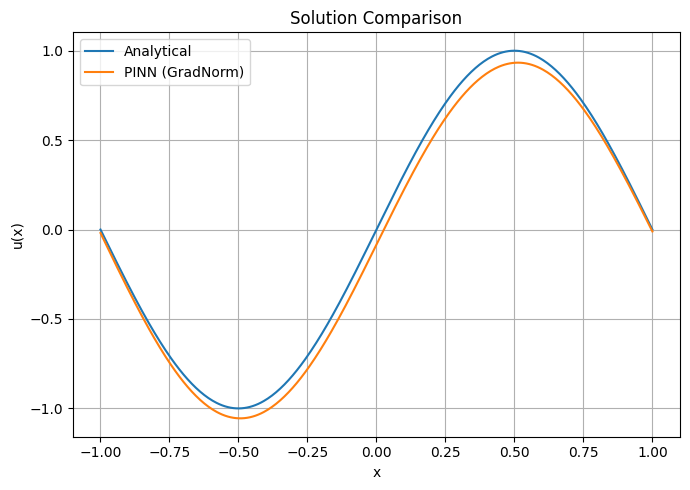

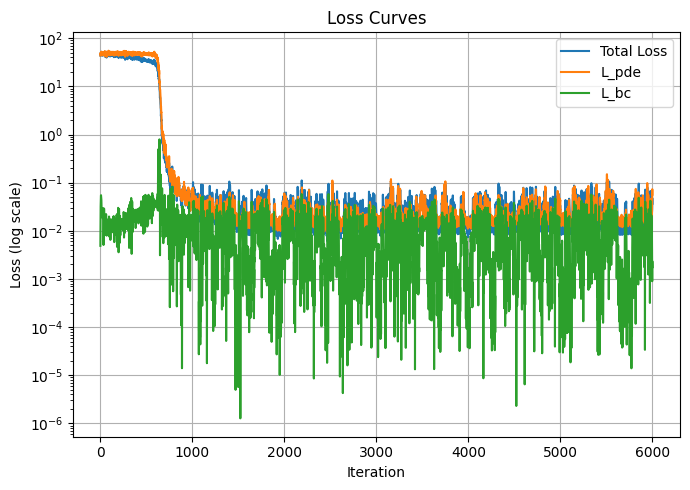

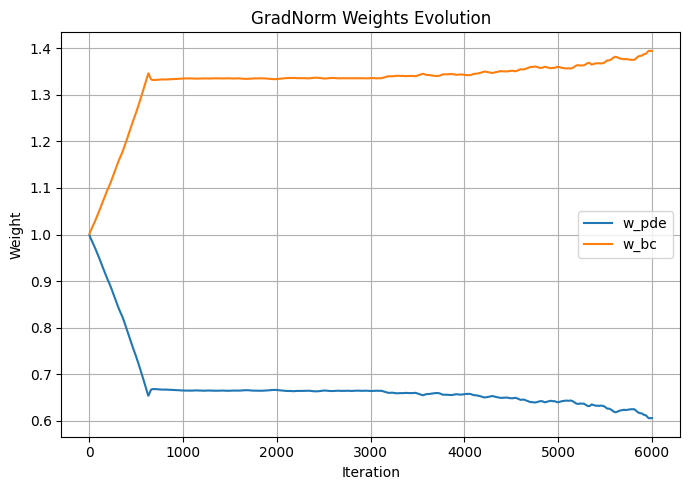

In [17]:
# This block corresponds to the `if __name__ == "__main__":` block in the script.
cfg = TrainConfig()
model, hist = train_gradnorm(cfg)
visualize(model, hist, cfg.device)

